# Importing Libraries

In [1]:
import numpy as np
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

In [2]:
!pip install hazm

In [3]:
import pandas as pd
from hazm import Normalizer, Stemmer, Lemmatizer
from nltk.stem.porter import PorterStemmer
from scipy.sparse import hstack
from pandas.api.types import CategoricalDtype
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import utils
import matplotlib.pyplot as plt

# Text Preprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
dataframe

,Unnamed: 0,Text,Category
0,0,\nخبرنامه دانشگاه علم و صنعت ايران \nشماره ياز...,Science and Culture
1,1,\nتا پايان سال 1378 دهها زمين فوتبال و \nسالن ...,Sport
2,2,\nانجمن توليدكنندگان تجهيزات صنعت نفت تشكيل شد...,Economy
3,3,\nكرتين براي سومين بار نخست وزير كانادا \nشد \...,Miscellaneous.World News
4,4,\nخداحافظ رفقا \nنمايندگان اروپاي شرقي در جام ...,Sport
...,...,...,...
150091,150091,\nمشكل بزرگ سدسازي \nوزير نيرو: \nدر كشور كمبو...,Miscellaneous
150092,150092,\nخودسوزي يك هوادار پ ك ك در شهر دياربكر \nترك...,Miscellaneous.Happenings
150093,150093,\nاز نيمه دوم سال جاري در 600 دستگاه \nاتوبوس ...,Miscellaneous.Urban
150094,150094,\nدر كتابخانه مركز دانشگاه \nتهران و دانشكده ه...,Science and Culture


In [6]:
dataframe['Category'].unique()

array(['Science and Culture', 'Sport', 'Economy',
       'Miscellaneous.World News', 'Miscellaneous.Urban', 'Social.Women',
       'Social', 'Literature and Art', 'Politics', 'Miscellaneous',
       'Economy.Bank and Bourse', 'Politics.Iran Politics', 'Tourism',
       'Social.Religion', 'Miscellaneous.Picture',
       'Miscellaneous.Happenings', 'Science and Culture.Science.Book',
       'Literature and Art.Art', 'Miscellaneous.Islamic Councils',
       'Literature and Art.Art.Cinema',
       'Science and Culture.Science.Information and Communication Technology',
       'Economy.Oil', 'Economy.Commerce', 'Natural Environment',
       'Science and Culture.Science', 'Economy.Industry',
       'Economy.Agriculture', 'Sport.World Cup',
       'Miscellaneous.Picture.Caricature', 'Literature and Art.Art.Music',
       'Literature and Art.Art.Theater',
       'Economy.Dwelling and Construction',
       'Science and Culture.Science.Medicine and Remedy',
       'Literature and Art.Literature']

there are many categories but some of them are sub-Categories of a main Category like 'Social.women' which is related to 'Social'.In order to clean our dataframe we need to merge this sub-categories into their main.

In [7]:
for i in range(len(dataframe)):
    if dataframe.loc[i, 'Category'].startswith('Miscellaneous'):
        dataframe.loc[i, 'Category'] = 'Miscellaneous'
    elif dataframe.loc[i, 'Category'].startswith('Economy'):
        dataframe.loc[i, 'Category'] = 'Economy'
    elif dataframe.loc[i, 'Category'].startswith('Politics'):
        dataframe.loc[i, 'Category'] = 'Politics'
    elif dataframe.loc[i, 'Category'].startswith('Sport'):
        dataframe.loc[i, 'Category'] = 'Sport'
    elif dataframe.loc[i, 'Category'].startswith('Science and Culture'):
        dataframe.loc[i, 'Category'] = 'Science and Culture'
    elif dataframe.loc[i, 'Category'].startswith('Social'):
        dataframe.loc[i, 'Category'] = 'Social'
    elif dataframe.loc[i, 'Category'].startswith('Literature and Art'):
        dataframe.loc[i, 'Category'] = 'Literature and Art'
    elif dataframe.loc[i, 'Category'].startswith('Tourism'):
        dataframe.loc[i, 'Category'] = 'Tourism'
    elif dataframe.loc[i, 'Category'].startswith('Natural Environment'):
        dataframe.loc[i, 'Category'] = 'Natural Environment'

We need to check if there is an unlabeled data.if we had a data with no label then we should remove it from our dataframe .Fortunatley , we don't have this issue

Now we shall split the data before further modifications

Next Step = Removing Stop Words

In [8]:
# def tokenize_text(text):
#     tokens = word_tokenize(text)
#     return tokens

In [9]:
# from hazm import word_tokenize
# dataframe['Tokenized_Text'] = dataframe['Text'].apply(tokenize_text)

In [10]:
dataframe

,Unnamed: 0,Text,Category
0,0,\nخبرنامه دانشگاه علم و صنعت ايران \nشماره ياز...,Science and Culture
1,1,\nتا پايان سال 1378 دهها زمين فوتبال و \nسالن ...,Sport
2,2,\nانجمن توليدكنندگان تجهيزات صنعت نفت تشكيل شد...,Economy
3,3,\nكرتين براي سومين بار نخست وزير كانادا \nشد \...,Miscellaneous
4,4,\nخداحافظ رفقا \nنمايندگان اروپاي شرقي در جام ...,Sport
...,...,...,...
150091,150091,\nمشكل بزرگ سدسازي \nوزير نيرو: \nدر كشور كمبو...,Miscellaneous
150092,150092,\nخودسوزي يك هوادار پ ك ك در شهر دياربكر \nترك...,Miscellaneous
150093,150093,\nاز نيمه دوم سال جاري در 600 دستگاه \nاتوبوس ...,Miscellaneous
150094,150094,\nدر كتابخانه مركز دانشگاه \nتهران و دانشكده ه...,Science and Culture


In [11]:
# Second = remove Stop Words
stopwords = np.load('/content/drive/MyDrive/Colab Notebooks/stopwords.npy')
stopwords

array(['و', 'در', 'به', 'از', 'که', 'این', 'را', 'با', 'است', 'برای',
       'آن', 'یک', 'خود', 'تا', 'کرد', 'بر', 'هم', 'نیز', 'گفت',
       'می\u200cشود', 'وی', 'شد', 'دارد', 'ما', 'اما', 'یا', 'شده',
       'باید', 'هر', 'آنها', 'بود', 'او', 'دیگر', 'دو', 'مورد',
       'می\u200cکند', 'شود', 'کند', 'وجود', 'بین', 'پیش', 'شده_است', 'پس',
       'نظر', 'اگر', 'همه', 'یکی', 'حال', 'هستند', 'من', 'کنند', 'نیست',
       'باشد', 'چه', 'بی', 'می', 'بخش', 'می\u200cکنند', 'همین', 'افزود',
       'هایی', 'دارند', 'راه', 'همچنین', 'روی', 'داد', 'بیشتر', 'بسیار',
       'سه', 'داشت', 'چند', 'سوی', 'تنها', 'هیچ', 'میان', 'اینکه', 'شدن',
       'بعد', 'جدید', 'ولی', 'حتی', 'کردن', 'برخی', 'کردند',
       'می\u200cدهد', 'اول', 'نه', 'کرده_است', 'نسبت', 'بیش', 'شما',
       'چنین', 'طور', 'افراد', 'تمام', 'درباره', 'بار', 'بسیاری',
       'می\u200cتواند', 'کرده', 'چون', 'ندارد', 'دوم', 'بزرگ', 'طی',
       'حدود', 'همان', 'بدون', 'البته', 'آنان', 'می\u200cگوید', 'دیگری',
       'خواهد_شد', 'کنیم', 

In [12]:
def remove_stopwords(text):
    # critical = 'برای'
    text = ' '.join([i for i in text.lower().split(' ') if i not in stopwords])
    return text

In [13]:
dataframe['Text'] = dataframe['Text'].apply(remove_stopwords)
dataframe

,Unnamed: 0,Text,Category
0,0,\nخبرنامه دانشگاه علم صنعت ايران \nشماره يازده...,Science and Culture
1,1,\nتا پايان سال 1378 دهها زمين فوتبال \nسالن ور...,Sport
2,2,\nانجمن توليدكنندگان تجهيزات صنعت نفت تشكيل \n...,Economy
3,3,\nكرتين براي سومين وزير كانادا \nشد \nژان كرتي...,Miscellaneous
4,4,\nخداحافظ رفقا \nنمايندگان اروپاي شرقي جام 200...,Sport
...,...,...,...
150091,150091,\nمشكل سدسازي \nوزير نيرو: \nدر كشور كمبود اعت...,Miscellaneous
150092,150092,\nخودسوزي يك هوادار پ ك ك شهر دياربكر \nتركيه ...,Miscellaneous
150093,150093,\nاز نيمه سال جاري 600 دستگاه \nاتوبوس كارت بل...,Miscellaneous
150094,150094,\nدر كتابخانه مركز دانشگاه \nتهران دانشكده هنر...,Science and Culture


In [14]:
# first = remove punctuation
punctuation = '!"#$%&\'()*+-./:;<=>?@\\^_`{|}~؟__-ء،ًٌٍَُِّْأإ؟'
punctuation

'!"#$%&\'()*+-./:;<=>?@\\^_`{|}~؟__-ء،ًٌٍَُِّْأإ؟'

In [15]:
def remove_punctuation(text):
    return ''.join([char for char in text if char not in punctuation ])

In [16]:
dataframe['Text'] = dataframe['Text'].apply(remove_punctuation)
# for text in x_train['Text']:
#   words = [word for word in text.split() if word.lower() not in punctuation]
#   text = "".join(words)

In [17]:
dataframe.head(10)

,Unnamed: 0,Text,Category
0,0,\nخبرنامه دانشگاه علم صنعت ايران \nشماره يازده...,Science and Culture
1,1,\nتا پايان سال 1378 دهها زمين فوتبال \nسالن ور...,Sport
2,2,\nانجمن توليدكنندگان تجهيزات صنعت نفت تشكيل \n...,Economy
3,3,\nكرتين براي سومين وزير كانادا \nشد \nژان كرتي...,Miscellaneous
4,4,\nخداحافظ رفقا \nنمايندگان اروپاي شرقي جام 200...,Sport
5,5,\nبراي مقابله فرسايش شديد خاك \nبزرگترين جزيره...,Miscellaneous
6,6,\nنيمي مردم جهان تحرك كافي \nهشدار سازمان بهدا...,Sport
7,7,\nزني پسوند پيشوند \nجايگاه زن سينماي ايران وگ...,Social
8,8,\nسن بلوغ ايران چيست \n \nبه بهانه همايش مسايل...,Social
9,9,\nرهبران پشتون تاجيك افغانستان \nانتظار تصميم ...,Miscellaneous


Normalizing \
When we normalize text, we attempt to reduce its randomness, bringing it closer to a predefined “standard”. This helps us to reduce the amount of different information that the computer has to deal with, and therefore improves efficiency. The goal of normalization techniques like stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form

In [20]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()

dataframe['Text'] = dataframe['Text'].apply(normalizer.normalize)
dataframe['Text'] = dataframe['Text'].apply(lemmatizer.lemmatize)

In [19]:
# dataframe = dataframe.drop(['Tokenized_Text'] , axis = 1)

# Train , Test and Split

In [18]:
dataframe['Category'].value_counts()

Miscellaneous          68733
Economy                21346
Politics               17803
Sport                  14328
Science and Culture    11959
Social                  8785
Literature and Art      5949
Natural Environment      851
Tourism                  342
Name: Category, dtype: int64

In [19]:
x= dataframe.iloc[:,0:2]
y= dataframe.iloc[:,2:3]
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [20]:
X_train

,Unnamed: 0,Text
5864,5864,\nبيماريهاي قلبي عروقي نخستين مرگ \nو مير كشور...
47463,47463,\nاجراي طرح ملي جنگلكاري دامنه جنوبي \nالبرز \...
14473,14473,\nيادداشت \nسخن سنجيده طهماسب مظاهري راجدي بگي...
60813,60813,\nهشت تيم خارجي دووميداني \n سرويس ورزشي تيم ه...
146598,146598,\nاجراي طرح زيست محيطي منطقه 22 تهران \nايرنا ...
...,...,...
119879,119879,\nتحقيق استيضاح \nبيل كلينتون مجلس نمايندگان \...
103694,103694,\nارزشمند كودكان بياموزيم \nموضوع اين جمله معر...
131932,131932,\nفهرستي براي حمله شصت كشور \nآمريكاي شمالي \n...
146867,146867,\nاتهام تازه اسرائيل عليه سوريه \nاسرائيل جريا...


In [21]:
y_train

,Category
5864,Miscellaneous
47463,Miscellaneous
14473,Economy
60813,Sport
146598,Miscellaneous
...,...
119879,Miscellaneous
103694,Social
131932,Politics
146867,Miscellaneous


In [22]:
balanced_train = pd.concat([X_train , y_train], axis=1)
balanced_train

,Unnamed: 0,Text,Category
5864,5864,\nبيماريهاي قلبي عروقي نخستين مرگ \nو مير كشور...,Miscellaneous
47463,47463,\nاجراي طرح ملي جنگلكاري دامنه جنوبي \nالبرز \...,Miscellaneous
14473,14473,\nيادداشت \nسخن سنجيده طهماسب مظاهري راجدي بگي...,Economy
60813,60813,\nهشت تيم خارجي دووميداني \n سرويس ورزشي تيم ه...,Sport
146598,146598,\nاجراي طرح زيست محيطي منطقه 22 تهران \nايرنا ...,Miscellaneous
...,...,...,...
119879,119879,\nتحقيق استيضاح \nبيل كلينتون مجلس نمايندگان \...,Miscellaneous
103694,103694,\nارزشمند كودكان بياموزيم \nموضوع اين جمله معر...,Social
131932,131932,\nفهرستي براي حمله شصت كشور \nآمريكاي شمالي \n...,Politics
146867,146867,\nاتهام تازه اسرائيل عليه سوريه \nاسرائيل جريا...,Miscellaneous


In [23]:
balanced_train['Category'].value_counts()

Miscellaneous          54950
Economy                17125
Politics               14247
Sport                  11392
Science and Culture     9566
Social                  7080
Literature and Art      4759
Natural Environment      684
Tourism                  273
Name: Category, dtype: int64

we choose 8000 values of 4 most populated class and all instances of other classes

In [24]:
class1 = balanced_train[balanced_train['Category'] == 'Miscellaneous']
class1 = class1.sample(8000, replace=False)
class2 = balanced_train[balanced_train['Category'] == 'Economy']
class2 = class2.sample(8000, replace=False)
class3 = balanced_train[balanced_train['Category'] == 'Politics']
class3 = class3.sample(8000, replace=False)
class4 = balanced_train[balanced_train['Category'] == 'Sport']
class4 = class4.sample(8000, replace=False)

In [25]:
class5 = balanced_train[balanced_train['Category'] == 'Science and Culture']
class5 = class5.sample(8000,replace = False)
class6 = balanced_train[balanced_train['Category'] == 'Social']
class6 = class6.sample(len(class6),replace = False)
class7 = balanced_train[balanced_train['Category'] == 'Literature and Art']
class7 = class7.sample(len(class7),replace = False)
class8 = balanced_train[balanced_train['Category'] == 'Natural Environment']
class8 = class8.sample(len(class8),replace = False)
class9 = balanced_train[balanced_train['Category'] == 'Tourism']
class9 = class9.sample(len(class9),replace = False)

In [26]:
balanced_data = pd.concat([class1, class2, class3, class4, class5, class6, class7, class8, class9], axis=0)

In [27]:
balanced_data

,Unnamed: 0,Text,Category
10112,10112,\nبا مردم \nضرورت اطلاع رساني \nهشدار وزير محت...,Miscellaneous
114406,114406,\nهي بي \nنام علمي speciosa hibe\nخانواده scro...,Miscellaneous
57738,57738,\nمناره بازار گسكر ملي \nمناره بازار گسكر دوره...,Miscellaneous
87433,87433,\nكلاسهاي آموزشي دوره تابستان خانه \nفرهنگ شمش...,Miscellaneous
127894,127894,\nاصلاح جاده خاوران ترين ضرورت اين \nايام \nسا...,Miscellaneous
...,...,...,...
15361,15361,\nرئيس سازمان ايرانگردي وجهانگردي اعلام كرد \n...,Tourism
50310,50310,\nنمايشگاه طبيعت نشاط زندگي ايلام \nگشايش يا...,Tourism
58490,58490,\nمدير طرح گسترش فضاي گردشگري غار عليصدر \nاعل...,Tourism
5457,5457,\nمعاون نظارت سازمان ايرانگردي وجهانگردي \nهمه...,Tourism


# free Unnecessary Space

In [28]:
del dataframe

In [29]:
del X_train

In [30]:
del y_train

In [31]:
del x,y

In [32]:
del class1,class2,class3,class4,class5,class6,class7,class8,class9

In [33]:
del balanced_data

# Tokenization and Feature Extraction

In [34]:
# import required module
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

text = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
number_of_features = text.fit_transform(balanced_train.loc[:,'Text'].values)

In [35]:
categories = pd.get_dummies(balanced_train['Category']).values

in order to avoid errors , we need to first convert the 'Text' column from a csr_matrix object back to a list of strings using toarray() method and then apply the TFIDF function to each string

# ANN

In [36]:
del balanced_train

In [37]:
# using tensorflow's keras
model = Sequential(
    [
        Dense(units=25, input_dim=number_of_features.toarray().shape[-1], activation="relu", name="input"),
        # Dense(units=64, activation="relu", name="layer1"),
        Dropout(0.4),
        Dense(units=16, activation="relu", name="layer1"),
        # Dense(units=64, activation="relu", name="layer3"),
        Dropout(0.2),
        Dense(units=9, activation="softmax", name="output")
    ],
    name="negar_model"
)
model.summary()

Model: "Negar's ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 25)                75025     
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 layer1 (Dense)              (None, 16)                416       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 output (Dense)              (None, 9)                 153       
                                                                 
Total params: 75594 (295.29 KB)
Trainable params: 75594 (295.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


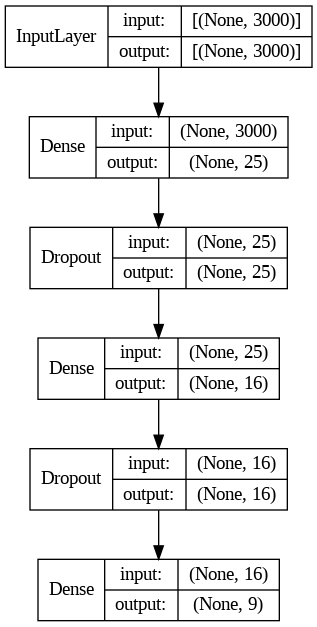

In [38]:
utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
history = model.fit(number_of_features.toarray(),categories , validation_data=(X_val, y_val), batch_size=64, epochs=10, verbose=2)

# Evaluation

Cross-Validation

In [ ]:
f = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],
         label='train accuracy',
         c='orange', ls='-')
plt.plot(history.history['val_accuracy'],
         label='val accuracy',
         c='dodgerblue', ls='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],
         label='train loss',
         c='orange', ls='--')
plt.plot(history.history['val_loss'],
         label='val loss',
         c='dodgerblue', ls='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

Confusion Matrix

In [ ]:
from sklearn import metrics
prediction = model.predict(X_val)
confusion_matrix = metrics.confusion_matrix(y_val, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

NameError: name 'metrics' is not defined

In [ ]:
def kfold_indices(data, k):
    fold_size = len(data) // k
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds

In [ ]:
# Define the number of folds (K)
k = 10

# Get the fold indices
fold_indices = kfold_indices(number_of_features.toarray(), k)

In [ ]:
from sklearn.metrics import accuracy_score
# Initialize a list to store the evaluation scores
scores = []

# Iterate through each fold
for train_indices, test_indices in fold_indices:
    X_train, y_train = number_of_features.toarray()[train_indices], categories[train_indices]
    X_test, y_test = number_of_features.toarray()[test_indices], categories[test_indices]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the accuracy score for this fold
    fold_score = accuracy_score(y_test, y_pred)

    # Append the fold score to the list of scores
    scores.append(fold_score)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(scores)
print("K-Fold Cross-Validation Scores:", scores)
print("Mean Accuracy:", mean_accuracy)

# Building a user Interface

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def greet(name, intensity):
    return "Hello , Tell Me Your News And I will Tell you it's Category !"

demo = gr.Interface(
    fn=greet,
    inputs=["text", "text"],
    outputs=["text"],
)

demo.launch()
